# Free Energy Components

One of the major advantages of ligandswap over other relative binding free energy methods is that it supports decomposition of the free energy averages into per-residue components. How it does this is [described in detail here](https://siremol.org/tutorials/ligandswap/theory.html).

What does this mean? Well, it means that ligandswap can give you an indication of which residues contribute most to the preference of a protein for binding to one ligand or another.

The raw data from which we can calculate the free energy components is held in the `results_XXXX.log` files that are produced in the `output` directory produced during a ligandswap simulation. We have example output files in the directory `output` (assuming you unpacked then in lesson 02)

In [1]:
outdir = "output"

There is one `results_XXXX.log` file produced from each iteration of the ligandswap calculation. For example, the file `results_1000.log` contains the results produced from the 1000th iteration of the calculation. Take a look at it here;

In [2]:
!cat output/results_1000.log

 Results for iteration 1000

delta_lambda == 0.001000
temperature == 298.150000 K


RELATIVE FREE ENERGY

TOTAL   BOUND   FREE
9.242028882051656   8.429372421087747   0.8126455425488016

RESIDUE FREE ENERGY COMPONENTS

RESIDUE    TOTAL    COULOMB    LJ
Residue( GLY : 20 )  -0.012742424393825984  -0.013240892526853593  0.000498468121363155
Residue( PRO : 21 )  -0.015963190385398996  -0.017642663239335596  0.0016794728670995566
Residue( THR : 22 )  0.01800295185931415  0.016655386616117283  0.0013475652458333244
Residue( LYS : 23 )  0.0009458762778542365  -0.0019099847235784365  0.002855860852005978
Residue( TRP : 84 )  0.02197102408923885  0.020970397033778804  0.0010006271145429596
Residue( THR : 85 )  -0.019991983201512145  -0.02032093396579437  0.00032895074499479236
Residue( PRO : 86 )  -0.007310627234665411  -0.007991106041585767  0.0006804787879856526
Residue( ASP : 87 )  -0.004934555955993402  -0.010753793155218034  0.00581921334094819
Residue( ILE : 88 )  -0.014560669777386076  

The file starts with the free energy calculated from the sampling performed at that iteration, e.g.

```
TOTAL   BOUND   FREE
9.242028882051656   8.429372421087747   0.8126455425488016
```

This splits the total free energy into the contribution from the protein box ("BOUND") and the contribution from the water box ("FREE"). In this case it shows that most of the free energy change (8.4 out of 9.2 kcal mol-1) comes from the protein box, implying that the better binding of the first ligand is due to better binding to the protein, rather than worse solubility in water.

After this, you can see free energy components for all of the residues that were within 15 A of the ligand, e.g.

```
RESIDUE    TOTAL    COULOMB    LJ
Residue( GLY : 20 )  -0.012742424393825984  -0.013240892526853593  0.000498468121363155
Residue( PRO : 21 )  -0.015963190385398996  -0.017642663239335596  0.0016794728670995566
Residue( THR : 22 )  0.01800295185931415  0.016655386616117283  0.0013475652458333244
Residue( LYS : 23 )  0.0009458762778542365  -0.0019099847235784365  0.002855860852005978
```

This shows that GLY20 has a tiny total contribution to the relative binding free energy of -0.01 kcal mol-1, which itself mostly comes from electrostatics (-0.01 kcal mol-1). The LJ contribution is even smaller, at 0.0005 kcal mol-1. This suggests that GLY20 is indifferent to whichever ligand is bound and so does not show any specificity to any ligand.

In contrast, find TRP145 and VAL146.

```
Residue( TRP : 145 )  1.0876637142440664  -0.6939942179058599  1.7747044598731816
Residue( VAL : 146 )  1.0336548161222636  0.5197159598051689  0.5139795375447672
```

These show larger free energy contributions. TRP145 is making about 1.1 kcal mol-1 contribution to the binding free energy. This is made up from -0.7 kcal mol-1 electrostatics and 1.8 kcal mol-1 LJ. This implies that replacing FM1 with CTI is overall favourable for TRP145 by +1.1 kcal mol-1. However, this masks that TRP145 has a stronger electrostatic interaction with CTI (by 0.7 kcal mol-1). The preference comes from a much weaker LJ interaction between TRP145 and CTI (by 1.8 kcal mol-1).

In contrast, VAL146 binds FM1 more strongly than CTI (by 1.0 kcal mol-1), with both stronger electrostatic and LJ interactions.

These values are taken from just one iteration from the simulation. Ideally we should average the components across all iterations that we class as "production" (so not discarded as equilibration). We can do this using a simple script.

First, we import pandas and matplotlib for data handling and plotting, and then also import the Sire modules we need to calculate averages (in Sire.Maths), identify parts of molecules (in Sire.Mol) and load molecules from files (in Sire.IO)

In [3]:
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'   # helps make things look better in Jupyter :-)

import Sire.Maths
import Sire.Mol
import Sire.IO

Next we set the range of iterations over which we want to average. We will use the last 60% again, so use iterations 400-1000

In [4]:
r = [400, 1000]

We need to process the files from results_0400.log to results_1000.log. The below line generates a list of all of these filenames.

In [5]:
filenames = ["%s/results_%04d.log" % (outdir,i) for i in range(r[0],r[1]+1)]

The next cell defines a function that reads all of the results files and extracts the average energy components. These are placed into a pandas DataFrame for easier manipulation later...

In [6]:
def getComponents(filenames):
    """Read all of the residue-based free energy components from the log files produced
       by a waterswap or ligandswap simulation (passed as a list of filenames). Return
       the average components as a pandas DataFrame"""
    avgs = {}
    resids = {}
    
    # Loop over all of the files...
    for filename in filenames:
        has_started=False
        for line in open(filename).readlines():
            # Read from the line "RESIDUE FREE ENERGY COMPONENTS" onwards...
            if line.find("RESIDUE FREE ENERGY COMPONENTS") != -1:
                has_started = True
            
            elif has_started:
                words = line.split()
                if len(words) == 8:
                    resname = words[1]
                    resnum = int(words[3])
                    total = float(words[-3])
                    coul = float(words[-2])
                    lj = float(words[-1])
                    key = "%s:%s" % (resname,resnum)
                    
                    if not key in avgs:
                        avgs[key] = [Sire.Maths.Average(), Sire.Maths.Average(), Sire.Maths.Average()]
                        if not resnum in resids:
                            resids[resnum] = [resname]
                        else:
                            resids[resnum].append(resname)
                    
                    # accumulate the average total, coulomb and LJ free energies
                    avgs[key][0].accumulate(total)
                    avgs[key][1].accumulate(coul)
                    avgs[key][2].accumulate(lj)
                    
                elif line.find("COMPONENTS") != -1:
                    break
    
    # Now sort the data into a pandas DataFrame
    resnums = list(resids.keys())
    resnums.sort()
    resnams = []
    total = []
    coul = []
    lj = []
    
    for resnum in resnums:
        for resname in resids[resnum]:
            key = "%s:%s" % (resname,resnum)
            avg = avgs[key]
            resnams.append(resname)
            total.append(avg[0].average())
            coul.append(avg[1].average())
            lj.append(avg[2].average())
    
    # The data is in lists which can be put into pandas columns. We will index the 
    # DataFrame using the residue number (assuming that they are all unique)
    return DataFrame( index = resnums,
                      data = {"name" : resnams, "total" : total, "coulomb" : coul, "LJ" : lj},
                      columns=["name", "total", "coulomb", "LJ"] )

Now use the above function to process all of the files and generate the pandas DataFrame...

In [7]:
components = getComponents(filenames)

The components are in a pandas DataFrame, so can be manipulated using any of the pandas functions. For example, look at the first few rows using the 'head' function

In [8]:
components.head()

,name,total,coulomb,LJ
20,GLY,-0.007971,-0.008476,0.000504
21,PRO,-0.032606,-0.034277,0.001671
22,THR,0.024826,0.023432,0.001394
23,LYS,0.100472,0.097634,0.002838
84,TRP,0.032046,0.031062,0.000984


There are components for all residues. Most of these are near zero, so it is a good idea to focus on those that are significant ( > 0.5 kcal mol-1 or < -0.5 kcal mol-1 )

In [9]:
components[ components.total.abs() > 0.5 ]

,name,total,coulomb,LJ
91,TYR,0.573888,0.012090,0.559628
145,TRP,1.863813,-0.683812,2.541203
146,VAL,0.966945,0.232170,0.734750
186,TYR,0.896290,0.072499,0.823758
188,CYX,0.502497,-0.000182,0.502671
191,GLU,0.655413,0.550810,0.104602
193,TYR,-0.834797,0.199166,-1.034109
263,ARG,0.599638,0.583976,0.015662
283,ARG,0.572921,0.371181,0.201740
322,ILE,1.344422,0.168973,1.175436


You can even use matplotlib to plot these :-)

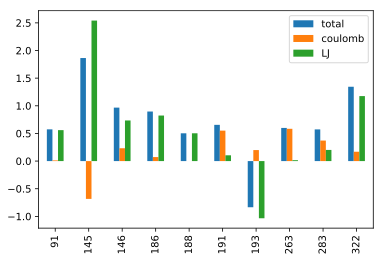

In [10]:
components[ components.total.abs() > 0.5 ].plot.bar()

The analysis shows which residues are making a contribution to binding. A negative sign shows that the residue prefers to bind the second ligand (the ligand bound at lambda=1), while a positive sign shows that the residue prefers to bind the first ligand (the ligand bound at lambda=0).

You can see that this analysis has highlighted TRP145 and VAL146 again. We can see that the analysis made from a single iteration above is confirmed by looking at the average free energy components. TRP145 is interesting as it electrostatically prefers CTI, but LJ prefers FM1 (as seen clearly in the graph above). This suggests that there is scope for better electrostatic targetting of TRP145 by modifying FM1.

You can use these components to begin to gain insight into why ligandswap predicts that one ligand is better than another. If the relative binding free energy is negative (ligand at lambda=1 binds better than the ligand at lambda=0) then this will be because this ligand has stronger interactions with the residues, and so you should see lots of negative residue free energy components. Similarly, if you get a positive free energy, then you should see lots of large positive components. 

In this case, the free energy is positive, and we see that this is driven mostly by TRP145 and ILE322, which strongly prefer to bind the first ligand (FMC). The second ligand (CTI) is really only preferred by TYR193.

The next step once you have identified residues is to look at the 3D structures sampled during the ligandswap calculation to see if you can understand from those why different residues have different preferences for the ligands. One way to help is to color-code residues based on the free energy components calculated above.

First, we need to get one of the PDB structures output by the ligandswap calculation. By default the calculation writes PDB files every 50 iterations from the protein box and the water box at the closest lambda value to 0 (lambda=0.005) and the closest lambda value to 1 (0.995). The files are called

* bound_mobile_XXXXX_YYYYY.pdb : the protein box files at iteration XXXXX and lambda value YYYYY, e.g. bound_mobile_001000_0.00500.pdb
* free_mobile_XXXXX_YYYYY.pdb : the water box files at iteration XXXXX and lambda value YYYYY, e.g. free_mobile_000500_0.99500.pdb

Note that, to save space, the files contain only the mobile atos in the simulation, so don't worry that they look like a ball and most of the protein and water is missing. The fixed atoms are in the simulation, they just aren't written to these files. 

To color-code the residues, we first need to read one of the protein-box files...

In [11]:
system = Sire.IO.MoleculeParser.read("%s/bound_mobile_001000_0.00500.pdb" % outdir)

Here is a function that colour-codes the protein(s) based on the passed pandas DataFrame

In [12]:
def colourProtein(s, data, column):
    """Colour-code the proteins in the passed system using the data contained in the passed dataframe, using the
       specified column"""
    
    # first find the maximum absolute value - we will scale linearly from there
    vals = data[column]
    maxval = vals.abs().max()
    
    # now, find all proteins in the system
    molnums = Sire.Mol.MolWithResID(Sire.Mol.ResName("ALA")).map(s)
    
    for molnum in molnums:
        protein = s[molnum]
    
        # now create an AtomFloatProperty that will contain a number for each atom
        # in each residue. This will be from 0-100, with 0 representing -maxval, 
        # 50 representing 0 and 100 representing maxval
        betas = Sire.Mol.AtomFloatProperty(protein, 50.0)
    
        for x in data.index:
            resnum = Sire.Mol.ResNum(int(x))
            resnam = Sire.Mol.ResName(data.name[x])
            value = vals[x]
        
            scaled = 50.0 + 50.0*(value/maxval)
        
            # issues with beta mean it must lie between 0 and 99.99
            if scaled < 0:
                scaled = 0.0
            elif scaled > 99.99:
                scaled = 99.99
          
            try:
                residue = protein[ resnam + resnum ]
        
                for atom in residue.atoms():
                    betas.set(atom.cgAtomIdx(), scaled)
            except:
                pass
            
        # Set the 'beta_factor' property as this is the name used for the 'beta_factor'
        # value by the PDB writer
        protein = protein.edit().setProperty("beta_factor", betas).commit()
    
        # save the updated protein in the system
        s.update(protein)
        
    # return the updated system
    return s

We will use this function to update the protein by colouring it using the "beta" property from the "total" free energy components.

In [13]:
system = colourProtein(system, components, "total")

Finally, we write this system out to a PDB file that you can load into any molecular visualiser

In [14]:
Sire.IO.MoleculeParser.write(system, "colourcoded.pdb")

['/home/workshops/xswaps/ligandswap/colourcoded.pdb']

You can now download this PDB file using the Jupyter interface. Load it into a molecular viewer, for example VMD. Select the protein and colour it by beta factor. You should see the residues that contribute strongly to the binding free energy highlighted in the 3D view. For example, here is the view I've made using VMD...

![Colour-coded protein](images/colorcoded.jpg)

(he protein is coloured using "beta" and the licorice view is selected using
